# Requirements

Importing the necessary libraries.

In [1]:
import pandas as pd
import numpy as np

import datetime
import pytz
import requests
from pandas.io.json import json_normalize

import pickle

import os

import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.linear_model import LinearRegression

Some useful functions to support the constructions in this project.

In [2]:
def expand_date_in_dataframe(df):
    """
    It breaks the date attibute (assuming it's a datetime) of a dataframe in more fileds
    for year, month, day, week, day of week, day of year and timestamp
    """
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['week'] = df.date.dt.week
    df['dayofweek'] = df.date.dt.dayofweek
    df['dayofyear'] = df.date.dt.dayofyear
    df['timestamp'] = df.date.values.astype(np.int64)

def str_to_datetime(str_date):
    """ Converts a string into a datetime """
    return datetime.datetime.strptime(str_date, '%Y-%m-%d')

def datetime_array_to_dataframe(days):
    """ Gets a data frame from an array of dates, i's intedded to be applied to an array of datetime """
    return pd.DataFrame({'date': days})

# Dataset

In [3]:
class Dataset:
    """
    This class is used to manage the dataset that contains the hsitoric stock prices
    for the companies contemplated in the Dow Jones Industrial Average.
    """

    """ Ticker symbols of the companies contemplated in the  Dow Jones Industrial Average """
    DJIA_TICKERS = [
        'BA',   'PFE', 'MCD', 'WMT', 'KO',   'MRK',  'HD',   'V',   'JNJ',  'VZ',
        'CSCO', 'AXP', 'TRV', 'DIS', 'MSFT', 'UNH',  'DWDP', 'CAT', 'AAPL', 'UTX',
        'MMM',  'JPM', 'IBM', 'GS',  'XOM',  'INTC', 'NKE',  'CVX', 'PG',   'WBA' ]

    """ Value used to get the historical data from 5 years ago """
    HIST_5Y = '5y'

    """ Value used to get the historical data from 1 year ago """
    HIST_1Y = '1y'

    """ Value used to get the historical data from 1 month ago """
    HIST_1M = '1m'

    """
    This is the template to create the URL to extract historical stock prices
    from the IEX API.
    """
    __IEX_API_URL_TEMPLATE = 'https://api.iextrading.com/1.0/stock/{}/chart/{}'


    def __init__(self, dataframe=None):
        self.dataframe = dataframe


    @staticmethod
    def __format_dataframe(df):
        formated_df = df.drop(['label',
                               'change', 'changeOverTime', 'changePercent',
                               'high', 'low', 'open',
                               'unadjustedVolume', 'volume', 'vwap'],
                              axis=1)

        expand_date_in_dataframe(formated_df)
        return formated_df


    @staticmethod
    def __get_dataframe_for_ticker(ticker_symbol, hist_period):
        r = requests.get(url=Dataset.__IEX_API_URL_TEMPLATE.format(ticker_symbol.lower(), hist_period))
        df = json_normalize(r.json())

        df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
        df.insert(loc=0, column='symbol', value=ticker_symbol)

        return Dataset.__format_dataframe(df)


    @staticmethod
    def __get_djia_dataframe(hist_period):
        df = None

        for ticker_symbol in Dataset.DJIA_TICKERS:
            if df is None:
                df = Dataset.__get_dataframe_for_ticker(ticker_symbol, hist_period)
            else:
                df = df.append(Dataset.__get_dataframe_for_ticker(ticker_symbol, hist_period))

        return df


    @staticmethod
    def __update_djia_dataframe(df):
        last_recorded_day = max(df.date)
        today = datetime.datetime.now()
        days_to_update = (today - last_recorded_day).days

        hist_period = Dataset.HIST_5Y

        if days_to_update < 1:
            return df
        elif days_to_update < 28:
            hist_period = Dataset.HIST_1M
        elif days_to_update < 365:
            hist_period = Dataset.HIST_1Y

        last_df = Dataset.__get_djia_dataframe(hist_period)

        return df.append(last_df).drop_duplicates(['symbol', 'date'], keep='last')


    @staticmethod
    def loadDatasetFromFile(file_name):
        with open(file_name, 'rb') as fp:
            return Dataset(pickle.load(fp))


    def saveDataToFile(self, file_name=None):
        if file_name is None:
            file_name = os.path.join(
                'data',
                'djia_{:%Y%m%d}-{:%Y%m%d}.pkl'.format(min(self.dataframe.date), max(self.dataframe.date)))

        with open(file_name, 'wb') as fp:
            pickle.dump(self.dataframe, fp)


    def createData(self, hist_period=HIST_5Y):
        self.dataframe = Dataset.__get_djia_dataframe(hist_period)


    def updateData(self):
        self.dataframe = Dataset.__update_djia_dataframe(self.dataframe)


    def getDataframe(self, ticker_symbol=None, from_date=None, to_date=None):
        df = self.dataframe

        if ticker_symbol is not None:
            if isinstance(ticker_symbol, str):
                df = df.query("symbol == '{}'".format(ticker_symbol))
            elif isinstance(ticker_symbol, list):
                ticker_symbol_query = None
                for t in ticker_symbol:
                    ticker_symbol_exp = "symbol == '{}'".format(t)
                    if ticker_symbol_query is None:
                        ticker_symbol_query = ticker_symbol_exp
                    else:
                        ticker_symbol_query += "or " + ticker_symbol_exp
                df = df.query(ticker_symbol_query)

        if from_date is not None:
            df = df.query("date >= '{}'".format(from_date))

        if to_date is not None:
            df = df.query("date <= '{}'".format(to_date))

        return df


    def getSubset(self, ticker_symbol=None, from_date=None, to_date=None):
        df = self.getDataframe(ticker_symbol=ticker_symbol, from_date=from_date, to_date=to_date)
        return Dataset(df)

# Trading days

In [4]:
class TradingDaysHelper:

    def __init__(self, market_holidays_file='market_holidays.txt'):
        self.market_holidays = []

        with open(market_holidays_file) as f:
            lines = f.readlines()

        for line in lines:
            self.market_holidays.append(datetime.datetime.strptime(line.strip(), '%Y-%m-%d'))


    def __is_trading_day(self, day):
        day_of_week = day.weekday()
        if day_of_week == 5 or day_of_week == 6 or day in self.market_holidays:
            return False
        else:
            return True


    def get_trading_days_in_range(self, start_date, end_date):
        trading_days = []

        current_day = start_date
        while (current_day <= end_date):
            if self.__is_trading_day(current_day):
                trading_days.append(current_day)
            current_day += datetime.timedelta(days=1)

        return trading_days

# Models

In [7]:
class StockForecasterModel:
    def __init__(self, ticker_symbol, dataset, trading_days_helper):
        self.ticker_symbol = ticker_symbol
        self.dataset = dataset
        self.trading_days_helper = trading_days_helper

    def train(self, start_date, end_date):
        raise NotImplementedError("Please Implement this method")

    def predict(self, from_date, to_date):
        raise NotImplementedError("Please Implement this method")

In [10]:
class LinearStockForecaster(StockForecasterModel):

    def __init__(self, ticker_symbol, dataset, trading_days_helper):
        StockForecasterModel.__init__(self, ticker_symbol, dataset, trading_days_helper)

    def train(self, start_date=None, end_date=None):
        training_set = self.dataset.getDataframe(ticker_symbol=self.ticker_symbol,
                                                 from_date=start_date, to_date=end_date)

        x = training_set.drop(['symbol', 'date', 'close'], axis=1)
        y = training_set.close

        self.model = LinearRegression()
        self.model.fit(x, y)

    def predict(self, from_date, to_date):
        days_to_predict = self.trading_days_helper.get_trading_days_in_range(from_date, to_date)

        x = datetime_array_to_dataframe(days_to_predict)
        expand_date_in_dataframe(x)
        x = x.drop(['date'], axis=1)

        y = self.model.predict(x)
        
        return pd.DataFrame({'symbol': self.ticker_symbol, 'date': days_to_predict, 'predicted_price': y})

# Analysis

In [12]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [44]:
def perform_test(results, subplot,
                 dataset, ticker_symbol, model_constructor,
                 training_start, training_end,
                 validation_days=[1, 7, 15, 30, 60, 90, 180]):

    training_ds = ds.getSubset(ticker_symbol=ticker_symbol,
                               from_date=training_start, to_date=training_end)

    validation_start = training_end + datetime.timedelta(days=1)
    validation_ds = ds.getSubset(ticker_symbol=ticker_symbol,
                                 from_date=validation_start ,
                                 to_date=validation_start + datetime.timedelta(days=max(validation_days)))

    model = model_constructor(ticker_symbol, training_ds, trading_days_helper)
    model.train(start_date=training_start, end_date=training_end)

    for v in validation_days:
        validation_end = validation_start + datetime.timedelta(days=v)
        preds = model.predict(validation_start, validation_end)
        validation_df = validation_ds.getDataframe(ticker_symbol=ticker_symbol,
                                                   from_date=validation_start, to_date=validation_end)

        results.append({'symbol': ticker_symbol,
                        'forecasting_days': v,
                        'RMSE': rmse(preds.predicted_price.values, validation_df.close.values)})

    subplot.plot(training_ds.dataframe.date, training_ds.dataframe.close, label='Training')
    subplot.plot(validation_ds.dataframe.date, validation_ds.dataframe.close, label='Validation')
    subplot.plot(preds.date, preds.predicted_price, label='Prediction')

    return results

# POCs

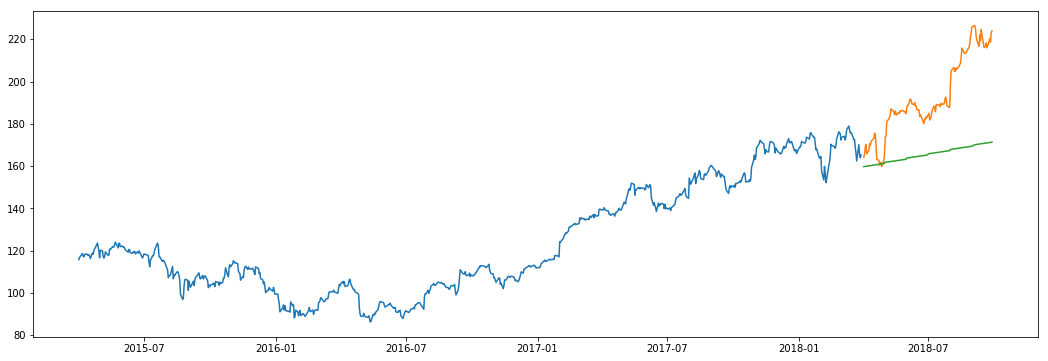

  symbol  forecasting_days       RMSE
0   AAPL                 1   4.358373
1   AAPL                 7   7.439488
2   AAPL                15   9.313558
3   AAPL                30   8.307899
4   AAPL                60  16.288076
5   AAPL                90  18.457619
6   AAPL               180  30.924584


In [46]:
trading_days_helper = TradingDaysHelper()
ds = Dataset.loadDatasetFromFile(os.path.join('data', 'djia_20140303-20190315.pkl'))

results = []

fig = plt.figure(figsize=(18, 6))

ax1 = fig.add_subplot(111)

perform_test(results, ax1, ds, 'AAPL', LinearStockForecaster,
             str_to_datetime('2015-04-01'), str_to_datetime('2018-03-31'))

plt.show()

#print(results)
results_df = pd.DataFrame(columns = ['symbol', 'forecasting_days', 'RMSE'], data = results)
print(results_df)

In [ ]:
ds = Dataset()
ds.loaDataFromFile('data/djia_20140303-20190315.pkl')
df = ds.getDataframe(ticker_symbol='AAPL', from_date=str_to_datetime('2015-04-01'), to_date=str_to_datetime('2018-03-31'))
plt.plot(df.date, df.close, label='Dates')

In [ ]:
ds = Dataset()
ds.loaDataFromFile('data/djia_20140303-20190315.pkl')
#ds.createData(hist_period=Dataset.HIST_1Y)
#ds.createData()

df = ds.getDataframe()
print('{} --> {}'.format(min(df.date), max(df.date)))

ds.updateData()
df = ds.getDataframe()
print('{} --> {}'.format(min(df.date), max(df.date)))

ds.saveDataToFile()

In [ ]:
perform_test(djia_ds, 'AAPL', LinearStockForecaster,
             str_to_datetime('2015-04-01'), str_to_datetime('2018-03-31'))

In [ ]:
h = TradingDaysHelper()
days = h.get_trading_days_in_range(TradingDaysHelper.str_to_datetime('2019-04-01'), TradingDaysHelper.str_to_datetime('2019-04-30'))

print(days)

In [ ]:
ds = Dataset()
ds.loaDataFromFile('data/djia_20140303-20190315.pkl')
trading_days_helper = TradingDaysHelper()

m = LinearStockForecaster('AAPL', ds, trading_days_helper)
m.train(str_to_datetime('2015-04-01'), str_to_datetime('2018-03-31'))
preds = m.predict(str_to_datetime('2018-04-01'), str_to_datetime('2018-06-30'))

training_set = ds.getDataframe('AAPL', str_to_datetime('2015-04-01'), str_to_datetime('2018-03-31'))
validation_set = ds.getDataframe('AAPL', str_to_datetime('2018-04-01'), str_to_datetime('2018-06-30'))

plt.plot(training_set.date, training_set.close, label='Training')
plt.plot(validation_set.date, validation_set.close, label='Validation')
plt.plot(preds.date, preds.predicted_price, label='Prediction')

print(preds)

In [6]:
ds = Dataset.loadDatasetFromFile(os.path.join('data', 'djia_20140303-20190315.pkl'))
trading_days_helper = TradingDaysHelper()
#print(ds.dataframe)

#ts = ds.getSubset(str_to_datetime('2015-04-01'), str_to_datetime('2018-03-31'))
#tdf = ts.getDataframe()
#print('{} --> {}'.format(min(tdf.date), max(tdf.date)))

tds = ds.getSubset(ticker_symbol=['AAPL', 'IBM', 'MSFT'], from_date=str_to_datetime('2019-03-01'), to_date=str_to_datetime('2019-03-10'))
print(tds.dataframe)

     symbol   close       date  year  month  day  week  dayofweek  dayofyear  \
1248   MSFT  112.53 2019-03-01  2019      3    1     9          4         60   
1249   MSFT  112.26 2019-03-04  2019      3    4    10          0         63   
1250   MSFT  111.70 2019-03-05  2019      3    5    10          1         64   
1251   MSFT  111.75 2019-03-06  2019      3    6    10          2         65   
1252   MSFT  110.39 2019-03-07  2019      3    7    10          3         66   
1253   MSFT  110.51 2019-03-08  2019      3    8    10          4         67   
1248   AAPL  174.97 2019-03-01  2019      3    1     9          4         60   
1249   AAPL  175.85 2019-03-04  2019      3    4    10          0         63   
1250   AAPL  175.53 2019-03-05  2019      3    5    10          1         64   
1251   AAPL  174.52 2019-03-06  2019      3    6    10          2         65   
1252   AAPL  172.50 2019-03-07  2019      3    7    10          3         66   
1253   AAPL  172.91 2019-03-08  2019    

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


         date  predicted_price symbol
0  2018-04-02       159.821527   AAPL
1  2018-04-03       159.871946   AAPL
2  2018-04-04       159.922364   AAPL
3  2018-04-05       159.972783   AAPL
4  2018-04-06       160.023201   AAPL
5  2018-04-09       160.174428   AAPL
6  2018-04-10       160.224846   AAPL
7  2018-04-11       160.275265   AAPL
8  2018-04-12       160.325683   AAPL
9  2018-04-13       160.376102   AAPL
10 2018-04-16       160.527328   AAPL
11 2018-04-17       160.577747   AAPL
12 2018-04-18       160.628165   AAPL
13 2018-04-19       160.678584   AAPL
14 2018-04-20       160.729002   AAPL
15 2018-04-23       160.880228   AAPL
16 2018-04-24       160.930647   AAPL
17 2018-04-25       160.981066   AAPL
18 2018-04-26       161.031484   AAPL
19 2018-04-27       161.081903   AAPL
20 2018-04-30       161.233129   AAPL
21 2018-05-01       161.780879   AAPL
22 2018-05-02       161.831297   AAPL
23 2018-05-03       161.881716   AAPL
24 2018-05-04       161.932134   AAPL
25 2018-05-0

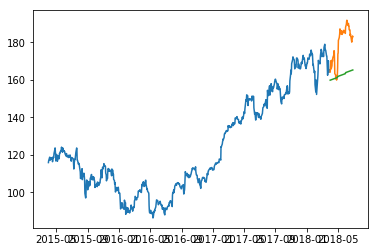

In [11]:
trading_days_helper = TradingDaysHelper()

ds = Dataset.loadDatasetFromFile(os.path.join('data', 'djia_20140303-20190315.pkl'))
training_ds = ds.getSubset(ticker_symbol='AAPL',
                           from_date=str_to_datetime('2015-04-01'),
                           to_date=str_to_datetime('2018-03-31'))
validation_ds = ds.getSubset(ticker_symbol='AAPL',
                             from_date=str_to_datetime('2018-04-01'),
                             to_date=str_to_datetime('2018-06-30'))

m = LinearStockForecaster('AAPL', training_ds, trading_days_helper)
m.train()
preds = m.predict(str_to_datetime('2018-04-01'), str_to_datetime('2018-06-30'))

plt.plot(training_ds.dataframe.date, training_ds.dataframe.close, label='Training')
plt.plot(validation_ds.dataframe.date, validation_ds.dataframe.close, label='Validation')
plt.plot(preds.date, preds.predicted_price, label='Prediction')

print(preds)